# Assignment 4: Fine-tuning a Pretrained Model Using LoRA

## 1. Exploratory Data Analysis (EDA) and Preprocessing

In [ ]:
from datasets import load_dataset_builder
from datasets import load_dataset
import pandas as pd

train_dataset = load_dataset('flytech/python-codes-25k', split='train')
print(train_dataset)

Dataset Name: flytech/python-codes-25k 
Description:  
features: {'input': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'instruction': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None)}
Dataset({
    features: ['input', 'text', 'instruction', 'output'],
    num_rows: 49626
})


In [ ]:
df = pd.DataFrame(train_dataset)
df.head()

,input,text,instruction,output
0,Setting up your daily to-do list...,Help me set up my daily to-do list! Setting up...,Help me set up my daily to-do list!,```python\ntasks = []\nwhile True:\n task =...
1,Creating a shopping list...,Create a shopping list based on my inputs! Cre...,Create a shopping list based on my inputs!,```python\nshopping_list = {}\nwhile True:\n ...
2,Calculating weekly phone usage...,Calculate how much time I spend on my phone pe...,Calculate how much time I spend on my phone pe...,"```python\ntotal_time = 0\nfor i in range(1, 8..."
3,Splitting the bill...,Help me split the bill among my friends! Split...,Help me split the bill among my friends!,```python\ntotal_bill = float(input('Enter the...
4,Organizing your movie list...,Organize my movie list into genres! Organizing...,Organize my movie list into genres!,```python\nmovie_list = {}\nwhile True:\n g...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49626 entries, 0 to 49625
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input        49626 non-null  object
 1   text         49626 non-null  object
 2   instruction  49626 non-null  object
 3   output       49626 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


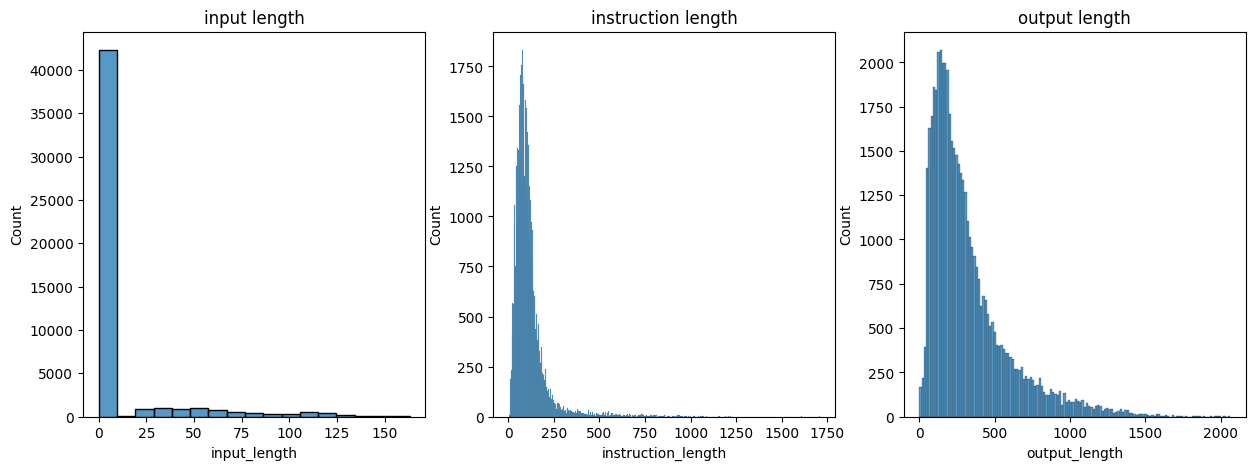

In [ ]:
# check the length distribution of the "input", "instruction" and "output" columns.
df['input_length'] = df['input'].map(lambda x: len(x))
df['instruction_length'] = df['instruction'].map(lambda x: len(x))
df['output_length'] = df['output'].map(lambda x: len(x))

# plot the length distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df['input_length'], ax=ax[0])
sns.histplot(df['instruction_length'], ax=ax[1])
sns.histplot(df['output_length'], ax=ax[2])
ax[0].set_title('input length')
ax[1].set_title('instruction length')
ax[2].set_title('output length')
plt.show()

In [ ]:
from collections import Counter
first_word = []
for example in train_dataset:
    if example['input']:
        first_word.append(example['input'].split()[0])

print(Counter(first_word).most_common(10))

[('AI', 1590), ('Writing', 1022), ('Implementing', 264), ('Downloading', 260), ('Fixing', 246), ('Checking', 158), ('Creating', 148), ('Searching', 134), ('Opening', 112), ('Automatically', 110)]


In [ ]:
task_categories = {'data manipulation': 0, 'file IO': 0, 'web scraping': 0, 'algorithm': 0}

for sample in train_dataset:
    instruction = sample['instruction'].lower()
    if 'data' in instruction:
        task_categories['data manipulation'] += 1
    elif 'file' in instruction:
        task_categories['file IO'] += 1
    elif 'web' in instruction:
        task_categories['web scraping'] += 1
    elif 'algorithm' in instruction:
        task_categories['algorithm'] += 1

print("Task categories counts:", task_categories)


Task categories counts: {'data manipulation': 4428, 'file IO': 1436, 'web scraping': 1526, 'algorithm': 2330}


In [ ]:
line_counts = []

for sample in train_dataset:
    code = sample['output']
    lines = code.split('\n')
    line_counts.append(len(lines))

print(f"Average number of lines per snippet: {sum(line_counts) / len(line_counts)}")

Average number of lines per snippet: 12.23322451940515


In [ ]:
input_output_examples = []

for i, sample in enumerate(train_dataset):
    if i < 3:
        input_output_examples.append((sample['instruction'], sample['input'], sample['output']))

for example in input_output_examples:
    print("instruction:", example[0])
    print("Input:", example[1])
    print("Output:\n", example[2])
    print("------")


instruction: Help me set up my daily to-do list!
Input: Setting up your daily to-do list...
Output:
 ```python
tasks = []
while True:
    task = input('Enter a task or type 'done' to finish: ')
    if task == 'done': break
    tasks.append(task)
print(f'Your to-do list for today: {tasks}')
```
------
instruction: Create a shopping list based on my inputs!
Input: Creating a shopping list...
Output:
 ```python
shopping_list = {}
while True:
    item = input('Enter an item or type 'done' to finish: ')
    if item == 'done': break
    quantity = input(f'Enter the quantity for {item}: ')
    shopping_list[item] = quantity
print(f'Your shopping list: {shopping_list}')
```
------
instruction: Calculate how much time I spend on my phone per week!
Input: Calculating weekly phone usage...
Output:
 ```python
total_time = 0
for i in range(1, 8):
    time = float(input(f'Enter phone usage in hours for day {i}: '))
    total_time += time
print(f'You spend approximately {total_time} hours per week on

## 2. Data Preprocessing

In [2]:
# !pip install transformers datasets evaluate accelerate peft # !pip install -i https://pypi.org/simple/ bitsandbytes

In [4]:
# mentioning datatypes for better documentation
from typing import Dict, List
from datasets import load_dataset, disable_caching, DatasetDict
from transformers import pipeline, AutoTokenizer, DataCollatorForSeq2Seq, RobertaForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import numpy as np
import evaluate
from functools import partial
import copy
bleu = evaluate.load("bleu")

In [5]:
disable_caching()

#### autoregressive training
redefine text for better autoregressive training method, in causal (autoregressive) language modeling, the model learns to predict the next token in a sequence given the tokens that precede it.

In [9]:
dataset = load_dataset('flytech/python-codes-25k', split = 'train')
small_dataset = dataset.select([i for i in range(200)])

# redefine text for better autoregressive training method
prompt_template = """There is an instruction for python code generation, Instruction: {instruction}\n The response is as follows,  Response:"""
answer_template = """{input}\n{output}"""

def redefine_text(rec):
    instruction = rec["instruction"]
    input = rec["input"]
    output = rec["output"]
    rec["prompt"] = prompt_template.format(instruction=instruction)
    rec["answer"] = answer_template.format(input=input, output=output)
    rec["text"] = rec["prompt"] + rec["answer"]
    return rec

small_dataset = small_dataset.map(redefine_text)
print(small_dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'instruction': 'Help me set up my daily to-do list!', 'input': 'Setting up your daily to-do list...', 'output': "```python\ntasks = []\nwhile True:\n    task = input('Enter a task or type 'done' to finish: ')\n    if task == 'done': break\n    tasks.append(task)\nprint(f'Your to-do list for today: {tasks}')\n```", 'text': "There is an instruction for python code generation, Instruction: Help me set up my daily to-do list!\n The response is as follows,  Response:Setting up your daily to-do list...\n```python\ntasks = []\nwhile True:\n    task = input('Enter a task or type 'done' to finish: ')\n    if task == 'done': break\n    tasks.append(task)\nprint(f'Your to-do list for today: {tasks}')\n```", 'prompt': 'There is an instruction for python code generation, Instruction: Help me set up my daily to-do list!\n The response is as follows,  Response:', 'answer': "Setting up your daily to-do list...\n```python\ntasks = []\nwhile True:\n    task = input('Enter a task or type 'done' to finis

## 3. Full Fine-tuning and LoRA fine-tuning

### 3.1 Load Data, Configure model

In [6]:
def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        preds_ids = np.argmax(predictions, axis=-1)
        decoded_preds = tokenizer.batch_decode(preds_ids, skip_special_tokens=True)

        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        formatted_preds = [pred.strip() for pred in decoded_preds]
        formatted_labels = [[label.strip()] for label in decoded_labels]

        results = bleu.compute(predictions=formatted_preds, references=formatted_labels)
        return {"bleu": results["bleu"]}

In [7]:
base_model = 'FacebookAI/roberta-base'

tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
max_length_of_input_token = 256

In [10]:
def preprocess(batch: Dict[str, List]):
    model_inputs = tokenizer(batch["text"], max_length=max_length_of_input_token, truncation=True, padding='max_length')
    model_inputs["labels"] = copy.deepcopy(model_inputs['input_ids'])
    return model_inputs

temp_dataset = small_dataset.map(
        partial(preprocess),
        batched=True,
        remove_columns=["instruction", "prompt", "answer", "input", "output"],).filter(lambda rec: len(rec["input_ids"]) <= max_length_of_input_token)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

In [11]:
train_test_split = temp_dataset.train_test_split(test_size=0.2, seed=0)
validation_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=0)

final_splits = DatasetDict({
    'train': train_test_split['train'],  # 80%
    'validation': validation_test_split['train'],  # 10%
    'test': validation_test_split['test']  # 10%
})
final_splits

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20
    })
})


### 3.2 Full fine-tuning

In [12]:
model = RobertaForCausalLM.from_pretrained(base_model, device_map="auto", is_decoder=True) # device_map is important for text generation
model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorForSeq2Seq(model = model, tokenizer=tokenizer, max_length=max_length_of_input_token, pad_to_multiple_of=8, padding='max_length')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [13]:
epochs = 10
lr = 1e-4
model_name = "roberta-lora"
training_args = TrainingArguments(
                    output_dir=model_name,
                    overwrite_output_dir=True,
                    per_device_train_batch_size=1,
                    per_device_eval_batch_size=32,
                    learning_rate=lr,
                    num_train_epochs=epochs,
                    logging_strategy="epoch",
                    evaluation_strategy="epoch",
                    save_strategy="epoch",)

trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=final_splits['train'],
        eval_dataset=final_splits["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
)

model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,1.883900,1.311635,0.328177
2,1.009500,1.198756,0.367986
3,0.730000,1.190926,0.367283
4,0.544500,1.209073,0.381719
5,0.421300,1.278391,0.403602
6,0.319400,1.281527,0.404549
7,0.239200,1.305249,0.411914
8,0.179900,1.337761,0.427701
9,0.140400,1.353706,0.418234
10,0.105500,1.379270,0.415788


In [14]:
test_results = trainer.evaluate(final_splits["test"])
print("Test Evaluation Results:", test_results)

Test Evaluation Results: {'eval_loss': 1.4368208646774292, 'eval_bleu': 0.43339719811256494, 'eval_runtime': 1.9095, 'eval_samples_per_second': 10.474, 'eval_steps_per_second': 0.524, 'epoch': 10.0}


### 3.3 LoRA Fine-tuning

In [ ]:
model = RobertaForCausalLM.from_pretrained(base_model, device_map="auto", is_decoder=True) # device_map is important for text generation
model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorForSeq2Seq(model = model, tokenizer=tokenizer, max_length=max_length_of_input_token, pad_to_multiple_of=8, padding='max_length')

In [ ]:
lora_r = 256
lora_alpha = 256
lora_dropout = 0.01

lora_config = LoraConfig(
                 r = lora_r,
                 lora_alpha = lora_alpha,
                 lora_dropout = lora_dropout,
                 bias="none",
                 task_type="CAUSAL_LM",
                 target_modules=["query", "key", "value"])

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 14,155,776 || all params: 138,853,209 || trainable%: 10.194777709458627


In [ ]:
epochs = 10
lr = 1e-4
model_name = "roberta-lora"
training_args = TrainingArguments(
                    output_dir=model_name,
                    overwrite_output_dir=True,
                    per_device_train_batch_size=1,
                    per_device_eval_batch_size=32,
                    learning_rate=lr,
                    num_train_epochs=epochs,
                    logging_strategy="epoch",
                    evaluation_strategy="epoch",
                    save_strategy="epoch",)

trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=final_splits['train'],
        eval_dataset=final_splits["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
)

model.config.use_cache = False

Epoch,Training Loss,Validation Loss,Bleu
1,1.296700,0.831533,0.266611
2,0.877700,0.710732,0.312546
3,0.750300,0.665590,0.334559
4,0.679700,0.623568,0.351961
5,0.638500,0.605601,0.354973
6,0.603500,0.590785,0.364074
7,0.572900,0.583201,0.373073
8,0.552600,0.576298,0.375943
9,0.540100,0.572639,0.375213
10,0.530500,0.568718,0.377491


Checkpoint destination directory roberta-lora/checkpoint-800 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory roberta-lora/checkpoint-1600 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [ ]:
test_results = trainer.evaluate(final_splits["test"])
print("Test Evaluation Results:", test_results)

Test Evaluation Results: {'eval_loss': 0.6464377641677856, 'eval_bleu': 0.355056555701167, 'eval_runtime': 2.742, 'eval_samples_per_second': 7.294, 'eval_steps_per_second': 0.365, 'epoch': 10.0}


In [ ]:
prompt = "Help me set up my daily to-do list!"
inf_pipeline = pipeline('text-generation', model=trainer.model, tokenizer=tokenizer, max_length=256, trust_remote_code=True)
response = inf_pipeline(prompt_template.format(instruction=prompt))[0]['generated_text']
messages = response.split("Response:")
messages

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCa

"Setting your daily list...\n```python\ndaily_list = input('Enter your daily daily list: ')\nprint(input('Enter your daily daily list: ')\nprint(f'Your daily daily list: '))\nprint(f'Daily_daily list: {daily_list}')\n```"